# **MLTiming Quickstart**

This notebook is a working example of how to use the MLTiming framework. In this quickstart we calculate the time of flight (TOF) distributions of events from a 22Na source located between two LaBr(Ce) truncated cone detectors at different positions along the LOR. In here we explain how to generate the training dataset from event data, train the models and display the results..

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from efficient_kan.src.efficient_kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (momentos, create_and_delay_pulse_pair, set_seed, 
                       calculate_gaussian_center, normalize, normalize_given_params, 
                       plot_gaussian, get_gaussian_params)
from Train_loops import train_loop_KAN

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_train.npz'))['data']
train_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_train.npz'))['data']
train_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_train.npz'))['data']


validation_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_val.npz'))['data']
validation_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_val.npz'))['data']
validation_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_val.npz'))['data']


test_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_test.npz'))['data']
test_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_test.npz'))['data']
test_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_test.npz'))['data']

# **IMPORTANT DEFINITIONS**

In [4]:
delay_time = 1           # Max delay to training pulses in ns
moments_order = 7        # Order of moments used
set_seed(42)             # Fix seeds
nbins = 71               # Num bins for all histograms
normalization_method = 'standardization'
time_step = 0.2          # Signal time step in ns
start = 47               # Start index of waveform cropping  
stop = 74                # Stop index of waveform cropping 
epochs = 500             # Number of epochs for training
lr = 1e-4             
batch_size = 32  
architecture = [moments_order, 3, 1, 1] # Define KAN model architecture   
positions = [-0.2, 0.0, 0.2]    # ToF of the different validation positions (in ns)

In [5]:
# Construct arrays from different source positions
train_data = np.concatenate((train_data_55, train_data_28, train_data_82), axis = 0)
validation_data = np.concatenate((validation_data_55, validation_data_28, validation_data_82), axis = 0)
test_data = np.concatenate((test_data_55, test_data_28, test_data_82), axis = 0)

# Crop waveforms
train_data = train_data[:,start:stop,:]
validation_data = validation_data[:,start:stop,:] 
test_data = test_data[:,start:stop,:]

# **DATASETS**

The 'virtual coincidences' are created using the create_and_delay_pulse_pair functions which takes an array of waveform and creates copies of each event and applies the random delays. Once the 'virtual coincidences' are created one can choose to use the waveforms directly as inputs or calculate input features. In this notebook, we calculate input features using the 'momentos' function. In this example, the different test positions are created by applying an specific delay to the centered position using the 'create position' function.. 

In [6]:
# Create Train/Validation/Test set
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], time_step, delay_time = delay_time)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], time_step, delay_time = delay_time)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], time_step, delay_time = delay_time)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], time_step, delay_time = delay_time)

TEST = test_data

# Calculate moments
M_Train_dec0 = momentos(train_dec0, order = moments_order) 
M_Train_dec1 = momentos(train_dec1, order = moments_order) 

M_Val_dec0 = momentos(val_dec0, order = moments_order) 
M_Val_dec1 = momentos(val_dec1, order = moments_order)

M_Test = momentos(TEST, order = moments_order)

# Normalize moments 
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

M_Val_dec0_channel0 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 0, method = normalization_method)
M_Val_dec0_channel1 =  normalize_given_params(M_Val_dec0, params_dec0, channel = 1, method = normalization_method)
M_Val_dec0 = np.stack((M_Val_dec0_channel0, M_Val_dec0_channel1), axis = -1)

M_Val_dec1_channel0 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 0, method = normalization_method)
M_Val_dec1_channel1 =  normalize_given_params(M_Val_dec1, params_dec1, channel = 1, method = normalization_method)
M_Val_dec1 = np.stack((M_Val_dec1_channel0, M_Val_dec1_channel1), axis = -1)

M_Test_norm_dec0 = normalize_given_params(M_Test, params_dec0, channel = 0, method = normalization_method)
M_Test_norm_dec1 = normalize_given_params(M_Test, params_dec1, channel = 1, method = normalization_method)
M_Test = np.stack((M_Test_norm_dec0, M_Test_norm_dec1), axis = -1)

In [16]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(REF_train_dec0[:,None]))
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(REF_train_dec1[:,None]))

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec0).float(), torch.from_numpy(REF_val_dec0[:,None]))
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Val_dec1).float(), torch.from_numpy(REF_val_dec1[:,None]))

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = batch_size, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = batch_size, shuffle = True)

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = len(val_dataset_dec0), shuffle = False)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = len(val_dataset_dec1), shuffle = False)

# **ML MODEL**

In this quickstart notebook we use the KAN architecture. However, MLP and CNN sample implementations are also available in Models.py. Feel free to use different architectures tailored to your needs!

In [17]:
# Initialize model
model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)  

In [18]:
# Execute train loop
loss_dec0, val_loss_dec0, test_dec0, val_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(M_Test[:,:,0]).float(), EPOCHS = epochs,  save = False) 
loss_dec1, val_loss_dec1, test_dec1, val_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(M_Test[:,:,1]).float(), EPOCHS = epochs,  save = False)

EPOCH 1:
LOSS train 0.004987538700923323
LOSS val 0.004746619146317244
EPOCH 2:
LOSS train 0.004428293593848745
LOSS val 0.003916712943464518
EPOCH 3:
LOSS train 0.003387156497997542
LOSS val 0.0027297502383589745
EPOCH 4:
LOSS train 0.0022906478432317577
LOSS val 0.0017569373594596982
EPOCH 5:
LOSS train 0.001431260430176432
LOSS val 0.0011033207410946488
EPOCH 6:
LOSS train 0.0009922454617917538
LOSS val 0.0008002292015589774
EPOCH 7:
LOSS train 0.000724415167622889
LOSS val 0.0005696713924407959
EPOCH 8:
LOSS train 0.0005249207278053897
LOSS val 0.00043032257235608995
EPOCH 9:
LOSS train 0.0004208020164320866
LOSS val 0.0003671725862659514
EPOCH 10:
LOSS train 0.0003704225339461118
LOSS val 0.00032999980612657964
EPOCH 11:
LOSS train 0.0003373714615008794
LOSS val 0.00030285530374385417
EPOCH 12:
LOSS train 0.00031086655507291046
LOSS val 0.0002768751874100417
EPOCH 13:
LOSS train 0.00028763544918426
LOSS val 0.00025577080668881536
EPOCH 14:
LOSS train 0.0002671486943436321
LOSS val

# **RESULTS**

The training loop returns directly the estimated time for the test set for detector 0 (test_dec0) and detector 1 (test_dec1) it is advisable to slice this array into the different positions and calculate their TOF separately. Moreover, to perform a global calibration use the 'calculate_gaussian_center_sigma' to get the centroid of on the TOF distributions and use to perform a translation of all the other positions together.

In [24]:
# Calculate TOF
TOF = test_dec0 - test_dec1

TOF_V00 = TOF[:,:test_data_55.shape[0]] 
TOF_V02 = TOF[:, test_data_55.shape[0] : test_data_55.shape[0] + test_data_28.shape[0]] 
TOF_V20 = TOF[:, test_data_55.shape[0]  + test_data_28.shape[0]:] 
    
# Calulate Test error
centroid_V00 = calculate_gaussian_center(TOF_V00, nbins = nbins, limits = 5) 

error_V02 = abs((TOF_V02 - centroid_V00[:, np.newaxis] - positions[0]))
error_V00 = abs((TOF_V00 - centroid_V00[:, np.newaxis] - positions[1]))
error_V20 = abs((TOF_V20 - centroid_V00[:, np.newaxis] - positions[2]))

#Get MAE
Error = np.concatenate((error_V02, error_V20, error_V00), axis = 1) 
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

0.08319154810827462


You can also plot different metrics' evolutions along the traing process such as coincidence MAE and detectors loss functions.

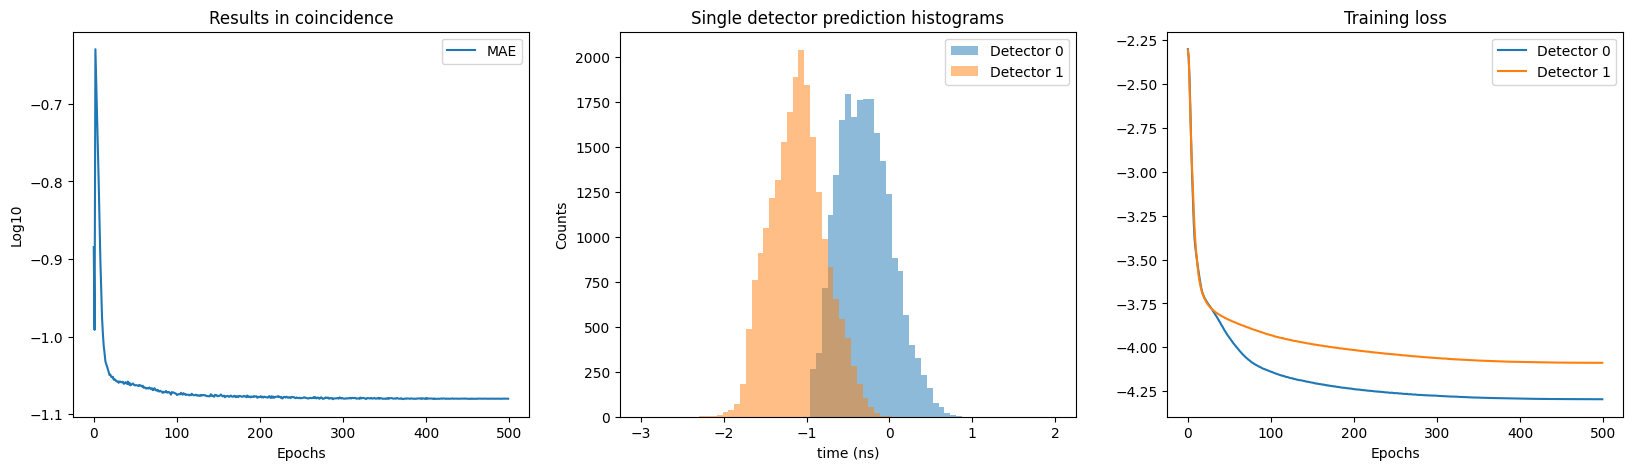

In [23]:
# Plot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:].astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1, :], bins = nbins, range = [-3, 2], alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1, :], bins = nbins, range = [-3, 2], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()

Plot the final TOF distribution results along their Gaussian fits and parameters.

V20: CENTROID(ns) = 0.193 +/- 0.001  FWHM(ns) = 0.244 +/- 0.001
V00: CENTROID(ns) = 0.000 +/- 0.001  FWHM(ns) = 0.238 +/- 0.001
V02: CENTROID(ns) = -0.190 +/- 0.001  FWHM(ns) = 0.240 +/- 0.001



Text(0, 0.5, 'Counts')

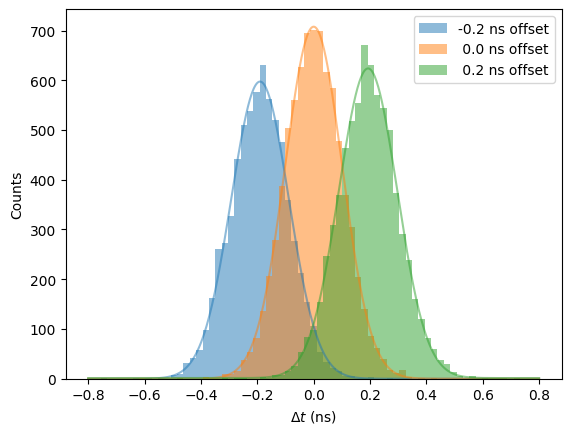

In [21]:
# Histogram and gaussian fit 
plot_gaussian(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')